# Описание проекта

Разработать вопросно-ответную систему на основе доĸумента.

Технические проблемы проекта:
1. Плохо построенный алгоритм векторного поиска, который не учитывает весь обьем токенов контекста. Потерянные токены ухудшают качество предсказаний модели. Метод векторного поиска ответов в контексте не учитывает односложные ответы типа "Да/Нет"
2. Недостаточный подбор гиперпараметров модели BERT.
3. Не все гипотезы подтверждены\опровергнуты экспериментально
4. Работающее решение использует ресурсы Kaggle

# Загрузка даных

In [254]:
import json
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter("ignore")
from datasets import load_dataset


# Проверяем и загружаем spaCy для русского и английского языков
try:
    import spacy
    from spacy.lang.ru.examples import sentences 
    nlp_ru = spacy.load("ru_core_news_sm", disable=['parser', 'ner'])
except:
    print('Скачиваю русский spaCy...')
    ! python -m spacy download -q ru_core_news_sm
    import spacy
    from spacy.lang.ru.examples import sentences 
    nlp_ru = spacy.load("ru_core_news_sm", disable=['parser', 'ner'])

try:
    nlp_en = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
except:
    print('Скачиваю английский spaCy...')
    ! python -m spacy download -q en_core_web_sm
    nlp_en = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Проверяем и загружаем NLTK stopwords
try:
    from nltk.corpus import stopwords
except:
    print('Устанавливаю nltk...')
    ! pip install -q nltk
    import nltk
    nltk.download('stopwords')

# Импортируем PyTorch и Transformers
import torch
import transformers
from transformers import DistilBertForQuestionAnswering, AutoTokenizer, DistilBertModel, AdamW
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score

# Установка и импорт Optuna
try:
    import optuna
except:
    print('Устанавливаю optuna...')
    ! pip install -q optuna
    import optuna


In [255]:
# Смотрим на структуру данных
with open('train.jsonl', 'r', encoding='utf-8') as file:
    json_data = [json.loads(line) for line in file]
json_data[0]

{'idx': 0,
 'passage': {'text': '(1) Но люди не могут существовать без природы, поэтому в парке стояли железобетонные скамейки — деревянные моментально ломали. (2) В парке бегали ребятишки, водилась шпана, которая развлекалась игрой в карты, пьянкой, драками, «иногда насмерть». (3) «Имали они тут и девок...» (4) Верховодил шпаной Артемка-мыло, с вспененной белой головой. (5) Людочка сколько ни пыталась усмирить лохмотья на буйной голове Артемки, ничего у неё не получалось. (6) Его «кудри, издали напоминавшие мыльную пену, изблизя оказались что липкие рожки из вокзальной столовой — сварили их, бросили комком в пустую тарелку, так они, слипшиеся, неподъёмно и лежали. (7) Да и не ради причёски приходил парень к Людочке. (8) Как только её руки становились занятыми ножницами и расчёской, Артемка начинал хватать её за разные места. (9) Людочка сначала увёртывалась от хватких рук Артемки, а когда не помогло, стукнула его машинкой по голове и пробила до крови, пришлось лить йод на голову «ухаж

In [256]:
#Напишем функцию, чтобы привести строки json в удобный для анализа DataFrame.
def todataframe(json_data):
    with open(json_data, 'r', encoding='utf-8') as file:
        json_data = [json.loads(line) for line in file]

    data = []
    # Извлечение данных из json-строк в список словарей
    for item in json_data:
        passage = item['passage']
        for question in passage['questions']:
            for answer in question['answers']:
                    columns = {
                        'id': item['idx'],
                        'num_sentences': len(re.findall(r'\(\d+\)', passage['text'])), # Отдельно выведем количество предложений для каждого текста
                        'text': passage['text'],
                        'q_id': question['idx'],
                        'question': question['question'],
                        'a_id': answer['idx'],
                        'answer': answer['text']
                    }
                    # Для test данных
                    if 'label' in answer:
                        columns['label'] = answer['label']
                    data.append(columns)
    return pd.DataFrame(data)

In [257]:
train = todataframe('train.jsonl')
test = todataframe('test.jsonl')
val = todataframe('val.jsonl')

# Эксплораторный анализ данных

## Первичный осмотр данных

In [258]:
print('Отрывков в тренировочной, тестовой и валидационной выборках: ', 
      train['id'].unique().shape[0], 
      test['id'].unique().shape[0], 
      val['id'].unique().shape[0])
# напишем функцию для первичного осмотра данных
def analiz(data):
    display(data.head())
    display(data.describe())
    display(data.info())
    print('Строк с пустыми значениям: ', (data.isna().all(axis=1)).sum())
    print('Дуликатов в датасете: ', data[data.duplicated()].shape[0])
    print('Пропущенных значений в столбцах: ', data.isna().sum())
    print('Данные содержат английские слова:', any(data[data.columns[3:]]
                                    .apply(lambda x: bool(re.compile(r'[a-zA-Z]')
                                    .search(str(x))))))
    print("Максимальное кол-во символов в текстах:", data['text'].str.len().max())


Отрывков в тренировочной, тестовой и валидационной выборках:  500 322 100


In [259]:
analiz(train)

,id,num_sentences,text,q_id,question,a_id,answer,label
0,0,11,"(1) Но люди не могут существовать без природы,...",0,Где бегала шпана?,0,В парке.,1
1,0,11,"(1) Но люди не могут существовать без природы,...",0,Где бегала шпана?,1,В лесу.,0
2,0,11,"(1) Но люди не могут существовать без природы,...",0,Где бегала шпана?,2,Около подъезда.,0
3,0,11,"(1) Но люди не могут существовать без природы,...",1,Почему Люда ударила Артема?,3,Он к ней приставал.,1
4,0,11,"(1) Но люди не могут существовать без природы,...",1,Почему Люда ударила Артема?,4,Он ее оскорбил.,0


,id,num_sentences,q_id,a_id,label
count,11950.000000,11950.000000,11950.000000,11950.000000,11950.000000
mean,220.043180,13.794728,1418.993389,5974.500000,0.450377
std,148.128668,2.585996,840.269779,3449.812193,0.497552
min,0.000000,7.000000,0.000000,0.000000,0.000000
25%,77.000000,12.000000,676.000000,2987.250000,0.000000
50%,209.000000,14.000000,1400.000000,5974.500000,0.000000
75%,347.000000,15.000000,2142.000000,8961.750000,1.000000
max,499.000000,21.000000,2896.000000,11949.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11950 entries, 0 to 11949
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             11950 non-null  int64 
 1   num_sentences  11950 non-null  int64 
 2   text           11950 non-null  object
 3   q_id           11950 non-null  int64 
 4   question       11950 non-null  object
 5   a_id           11950 non-null  int64 
 6   answer         11950 non-null  object
 7   label          11950 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 747.0+ KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  id               0
num_sentences    0
text             0
q_id             0
question         0
a_id             0
answer           0
label            0
dtype: int64
Данные содержат английские слова: True
Максимальное кол-во символов в текстах: 3399


In [260]:
analiz(test)

,id,num_sentences,text,q_id,question,a_id,answer
0,0,14,"""(1) Издательство Viking Press совместно с ком...",0,О чем дневник Анны Франк?,0,Дневник об отметках Анны.
1,0,14,"""(1) Издательство Viking Press совместно с ком...",0,О чем дневник Анны Франк?,1,Дневник о школьных годах девочки Анны.
2,0,14,"""(1) Издательство Viking Press совместно с ком...",0,О чем дневник Анны Франк?,2,О жизни еврейской девочки во время гонения евр...
3,0,14,"""(1) Издательство Viking Press совместно с ком...",0,О чем дневник Анны Франк?,3,"Анна описывала свою жизнь и жизнь близких, ког..."
4,0,14,"""(1) Издательство Viking Press совместно с ком...",1,Каким будет приложение Anne Frank App?,4,Приложение будет платным.


,id,num_sentences,q_id,a_id
count,7614.000000,7614.000000,7614.000000,7614.000000
mean,143.212503,13.910428,892.102180,3806.500000
std,98.071988,2.714995,525.375897,2198.116808
min,0.000000,9.000000,0.000000,0.000000
25%,50.000000,12.000000,430.000000,1903.250000
50%,135.500000,14.000000,886.500000,3806.500000
75%,234.000000,15.000000,1344.750000,5709.750000
max,321.000000,20.000000,1812.000000,7613.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614 entries, 0 to 7613
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             7614 non-null   int64 
 1   num_sentences  7614 non-null   int64 
 2   text           7614 non-null   object
 3   q_id           7614 non-null   int64 
 4   question       7614 non-null   object
 5   a_id           7614 non-null   int64 
 6   answer         7614 non-null   object
dtypes: int64(4), object(3)
memory usage: 416.5+ KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  id               0
num_sentences    0
text             0
q_id             0
question         0
a_id             0
answer           0
dtype: int64
Данные содержат английские слова: True
Максимальное кол-во символов в текстах: 2769


In [261]:
analiz(val)

,id,num_sentences,text,q_id,question,a_id,answer,label
0,0,12,(1) Самый первый «остров» Архипелага возник в ...,0,Почему Солженицына перевозили спецконвоем?,0,Так перевозили особо важных заключенных.,1
1,0,12,(1) Самый первый «остров» Архипелага возник в ...,0,Почему Солженицына перевозили спецконвоем?,1,"Потому, что был эмигрантом.",0
2,0,12,(1) Самый первый «остров» Архипелага возник в ...,0,Почему Солженицына перевозили спецконвоем?,2,"Потому, что он сам вырыл себе землянку.",0
3,0,12,(1) Самый первый «остров» Архипелага возник в ...,0,Почему Солженицына перевозили спецконвоем?,3,"Потому, что он побывал на пересылке Красная Пр...",0
4,0,12,(1) Самый первый «остров» Архипелага возник в ...,0,Почему Солженицына перевозили спецконвоем?,4,"Потому, что он был особо важным заключённым и ...",1


,id,num_sentences,q_id,a_id,label
count,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000
mean,49.764206,13.876063,262.685459,1117.000000,0.444295
std,28.456195,2.675084,154.312145,645.333247,0.496998
min,0.000000,8.000000,0.000000,0.000000,0.000000
25%,25.000000,13.000000,128.500000,558.500000,0.000000
50%,48.000000,13.000000,263.000000,1117.000000,0.000000
75%,75.000000,15.000000,395.000000,1675.500000,1.000000
max,99.000000,20.000000,528.000000,2234.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2235 non-null   int64 
 1   num_sentences  2235 non-null   int64 
 2   text           2235 non-null   object
 3   q_id           2235 non-null   int64 
 4   question       2235 non-null   object
 5   a_id           2235 non-null   int64 
 6   answer         2235 non-null   object
 7   label          2235 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 139.8+ KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  id               0
num_sentences    0
text             0
q_id             0
question         0
a_id             0
answer           0
label            0
dtype: int64
Данные содержат английские слова: True
Максимальное кол-во символов в текстах: 3323


### Вывод:

Мы имеем пронумерованные по предложениям открывки содержащие латинские и кирилические символы с составленными по ним вопросами и вариантами ответов. У каждого ответа на вопрос есть булева-отметка('label'), скорее всего отвечающая за правильность ответа и являющаяся таргет-признаком.

У каждого из текстовых данных есть уникальный идентификатор - idx. В ранее написанной функции мы выделили количество предложений в отрывках в отдельный столбец. Это должно помочь нам провести анализ данных. Во всех наборах данных содержатся как кирилические так и латинские символыю будет учитывать это при анализе и построении модели.

## Анализ распределения правильности ответов

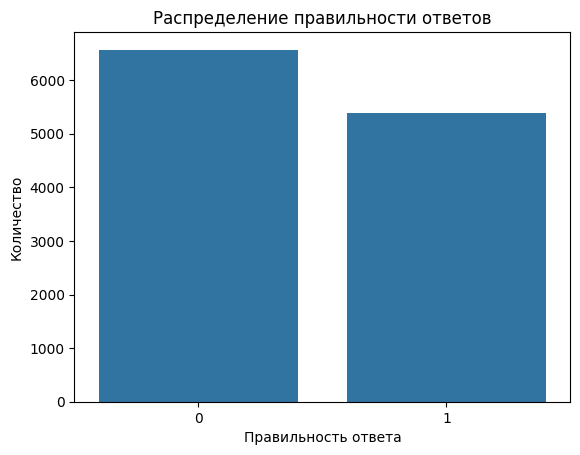

In [262]:
sns.countplot(data=train, x='label')
plt.title('Распределение правильности ответов')
plt.xlabel('Правильность ответа')
plt.ylabel('Количество')
plt.show()

### Вывод:

В тренировочном наборе данных превалирует 0, значит правильных ответов больше чем неправильных.

## Количество ответов на вопросы.

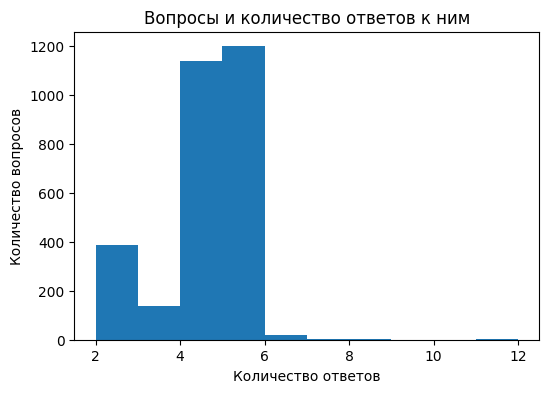

In [263]:
plt.figure(figsize=(6,4))
train.groupby('q_id')['a_id'].count().plot(kind='hist')
plt.title('Вопросы и количество ответов к ним')
plt.xlabel('Количество ответов')
plt.ylabel('Количество вопросов')
plt.show()

### Вывод:

График показывает, что большинство вопросов содержат от 4 до 6 ответов на них. Также можно найти вопросы, у которых по 12 ответов. 

## Анализ влияния количества ответов на вероятность ответить правильно

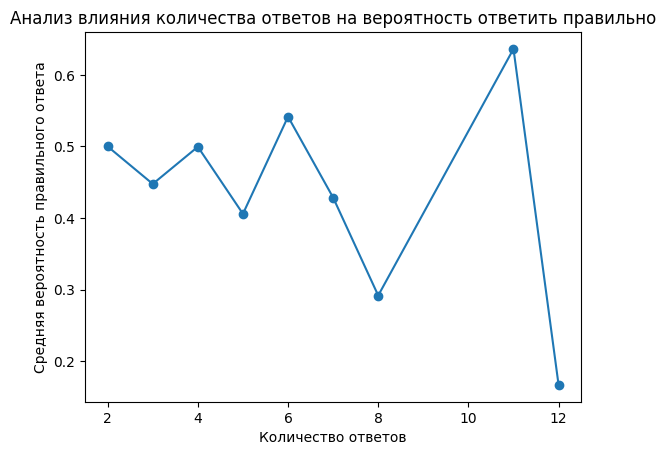

In [264]:
#Сгруппируйте данные по q_id для определения количества ответов на каждый вопрос.
grouped_data = train.groupby('q_id').agg(
    total_answers=('id', 'count'),
    incorrect_answers=('label', 'sum')
)

# Подсчитаем количество правильных ответов
grouped_data['correct_answers'] = grouped_data['total_answers'] - grouped_data['incorrect_answers']

#Для каждого вопроса рассчитайте вероятность выбора правильного ответа.
grouped_data['probability_correct'] = grouped_data['incorrect_answers'] / grouped_data['total_answers']

#Сгруппируйте данные по total_answers и рассчитайте среднюю вероятность выбора правильного ответа для каждого количества ответов.
aggregated_data = grouped_data.groupby('total_answers').agg(
    average_probability=('probability_correct', 'mean')
).reset_index()


plt.plot(aggregated_data['total_answers'], aggregated_data['average_probability'], marker='o')
plt.xlabel('Количество ответов')
plt.ylabel('Средняя вероятность правильного ответа')
plt.title('Анализ влияния количества ответов на вероятность ответить правильно')
plt.show()

### Вывод

Судя по построенному графику количество ответов на вопрос не увеличивает шансы ответить верно.

## Количество вопросов к отрывкам

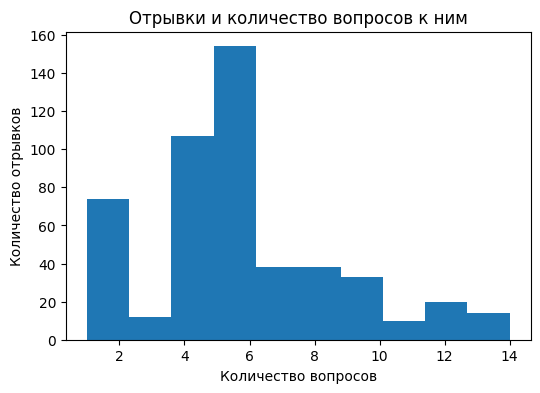

In [265]:
plt.figure(figsize=(6,4))
train.groupby('id')['q_id'].nunique().plot(kind='hist')
plt.title('Отрывки и количество вопросов к ним')
plt.xlabel('Количество вопросов')
plt.ylabel('Количество отрывков')
plt.show()

К каждому в отрывку с среднем по 4-6 вопросов.

## Количество предложений в отрывках

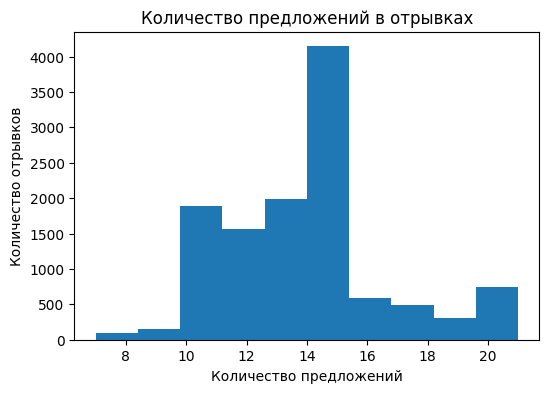

In [266]:
plt.figure(figsize=(6,4))
train['num_sentences'].plot(kind='hist')
plt.title('Количество предложений в отрывках')
plt.xlabel('Количество предложений')
plt.ylabel('Количество отрывков')
plt.show()

### Вывод:

В основном отрывки содержат 10-15 предложений.

## Анализ длины текстов и вопросов

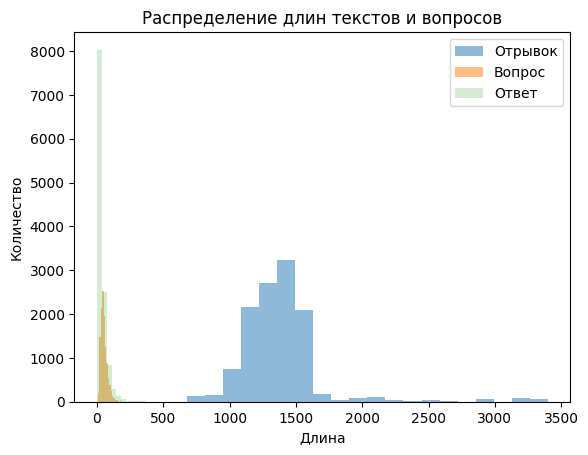

In [267]:
train['text_length'] = train['text'].apply(len)
train['question_length'] = train['question'].apply(len)
train['answer_length'] = train['answer'].apply(len)


# Визуализация распределения длин текстов и вопросов
plt.hist(train['text_length'], bins=20, alpha=0.5, label='Отрывок')
plt.hist(train['question_length'], bins=20, alpha=0.5, label='Вопрос')
plt.hist(train['answer_length'], bins=20, alpha=0.2, label='Ответ')
plt.legend(loc='upper right')
plt.xlabel('Длина')
plt.ylabel('Количество')
plt.title('Распределение длин текстов и вопросов')
plt.show()

### Вывод:

График позволяет визуализировать приблизительную длину текстов, вопросов и ответов на них. Так, длина отрывков обычно варирует в пределах 1000-1600 символов. Большая же часть задаваемых вопросов занимает до 200 символов. Ответов до 100, среди которых преобладают короткие ответы. Проверим информативность коротких ответов

In [268]:
print('Вопросов с длинной в один символ:', len(train[train['question_length'] == 1]))
print('Ответов с длинной в один символ:', len(train[train['answer_length'] == 1]))
train[train['answer_length'] == 1]


Вопросов с длинной в один символ: 0
Ответов с длинной в один символ: 2


,id,num_sentences,text,q_id,question,a_id,answer,label,text_length,question_length,answer_length
3346,90,20,(1)Наукой заниматься трудно. (2)Это хорошо зна...,758,Почему заниматься наукой необходимо?,3346,.,1,2210,36,1
6713,241,16,"""(1) Бывший мэр Москвы Юрий Лужков занялся упр...",1579,Чем занимается бывший мэр Москвы Юрий Лужков?,6713,.,1,1395,45,1


Кажется, это отсутствие ответа. Уберем такие строки их датасетов.

In [269]:
train = train[train['answer_length'] > 1]
val = val[val['answer'].str.len() > 1]

## Анализ взаимосвязи между длиной ответа и правильностью ответа

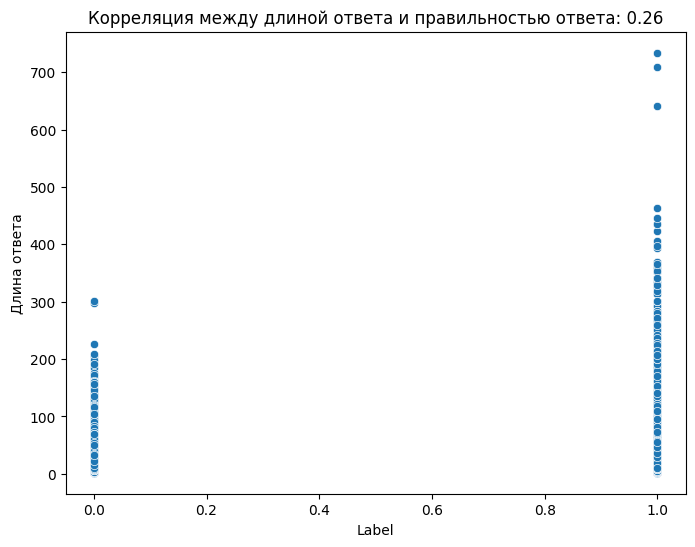

In [270]:
# Вычисляем корреляцию между 'label' и 'question_length'
correlation = train['label'].corr(train['answer_length'])
# Создаем график
plt.figure(figsize=(8, 6))
sns.scatterplot(x='label', y='answer_length', data=train)
plt.title(f'Корреляция между длиной ответа и правильностью ответа: {correlation:.2f}')
plt.xlabel('Label')
plt.ylabel('Длина ответа')
plt.show()

### Вывод 

Видимая связь между длиной ответа и его правильностью отсустствует.

## Топ-10 слов

Удалим все предлоги и лишние символы

In [271]:
russian_stopwords = stopwords.words("russian")
english_stopwords = stopwords.words("english")

def clear_text(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^а-яА-Яa-zA-Z]+", " ", text).strip().lower() # оставляет в тексте латинские и кирилические символы.
    text = " ".join([word for word in text.split() if word not in russian_stopwords])
    text = " ".join([word for word in text.split() if word not in english_stopwords])
    text = " ".join([word for word in text.split() if len(word) >= 2]) # удалим слова, которые короче 2 символов
    return text

columns = ['text', 'question', 'answer']
# Создадим отдельный 
top_words = pd.DataFrame()
for column in columns:
    top_words[column] = train[column].apply(clear_text)


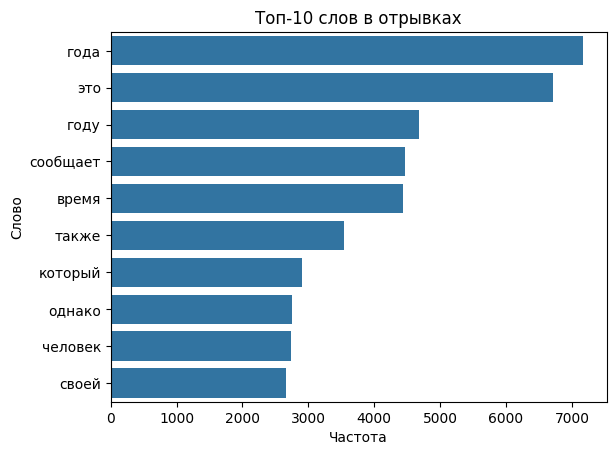

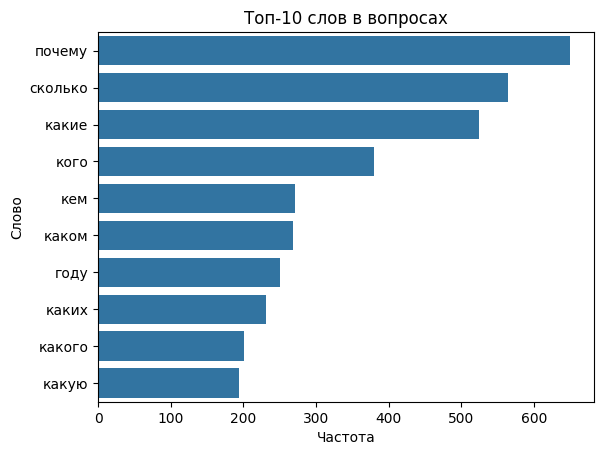

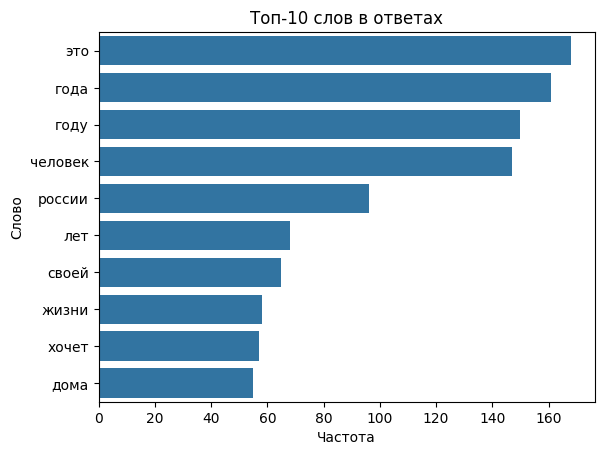

In [272]:
# Функция для нахождения наиболее частых слов
def get_most_common_words(text, num=10):
    words = Counter(" ".join(text).split()).most_common(num)
    return words

# Преобразование данных в DataFrame для визуализации
text = pd.DataFrame(get_most_common_words(top_words['text']), columns=['Слово', 'Частота'])
questions = pd.DataFrame(get_most_common_words(top_words['question']), columns=['Слово', 'Частота'])
answers = pd.DataFrame(get_most_common_words(top_words['answer']), columns=['Слово', 'Частота'])

# Визуализируем топ-10 слов
sns.barplot(x='Частота', y='Слово', data=text)
plt.title('Топ-10 слов в отрывках')
plt.show()

sns.barplot(x='Частота', y='Слово', data=questions)
plt.title('Топ-10 слов в вопросах')
plt.show()

sns.barplot(x='Частота', y='Слово', data=answers)
plt.title('Топ-10 слов в ответах')
plt.show()



### Вывод 

Судя по представленным словам в графиках в текстах отрывков очень много исторического контекста - популярны слова 'год', 'время', частица 'это' может свидетельствовать о познавательном характере текстов.

## Общий вывод:

Мы имеем пронумерованные по предложениям открывки содержащие латинские и кирилические символы с составленными по ним вопросами и вариантами ответов. У каждого ответа на вопрос есть метка ('label'), свидетельствующая о его правильности.

* Дубликатов или полей с отсутствием данных не имеем.
* У каждого из текстовых данных есть уникальный идентификатор.
* В данных превалирует 0 значения признака 'label', то есть правильных ответов больше чем неправильных.
* График показывает, что большинство вопросов содержат от 4 до 6 ответов на них. Также можно найти вопросы, у которых по вариантов 12 ответов. 
* К каждому в отрывку с чаще всего по 4-6 вопросов.
* В основном отрывки содержат по 10-15 предложений.
* Чаще всего на каждый отрывок приходится по 100 ответов на вопросы.
* Длина отрывков обычно варирует в пределах 1000-1600 символов. Вопросы: до 200 символов. Ответы: до 100.
* В поле ответов было обнаружено и удалено 2 аномалии.
* Количество ответов на вопрос не увеличивает шансы ответить верно.
* В данных нет линейной зависимости между количеством ответов и вероятностью ответить правильно.
* Отрывки зачастую несут в себе исторический и познавательный контекст - популярны слова 'год', 'время', частица 'это' 

# Построение гипотез для решения задачи

### Гипотеза 1

Использование моделей, основанных на трансформерах которые хорошо работают с контекстуальным пониманием текстов, улучшит качество. 
Ответы ответы на вопросы занимают до 100 символов и в них нет связи между длиной ответа и его правильностью, они не копируют формулировки контекста. Ответы не односложны и требуют системы, способной понимать и интерпретировать контекст как вопроса, так и текста по которому он составлен для нахождения правильного ответа.

### Гипотеза 2

Если не скрывать неправильные ответы - производительность модели будет лучше.


### Гипотеза 3 

Мы предполагаем, что тренировочные данные размечены верно.


### Гипотеза 4 

Контекста модели всегла будет хватать чтобы при помощи док ответить на вопрос. 
Учитывая, что каждый документ содержит множество вопросов, относящихся к различным частям текста, важно, чтобы модель могла корректно понимать и интерпретировать контекст каждой части текста. Это необходимо для того, чтобы точно соотнести вопросы с соответствующими частями текста и более предоставить точные ответы. Не попадание в допустимый обьем токенов приведет к снижению точности предсказаний модели.

### Гипотеза 5

Модель с поддержкой второго языка лучше. Данные содержат наряду с кирилицей латинские символы, точность модели будет повышена, если модель будет обучена и настроена на работу с двумя языками одновременно.

### Гипотеза 6

Модель не может использоваться для важных задач из-за высокой вероятности галлюцинации. 

# Выбрать и обосновать метрики качества

* Точность (Accuracy): Это базовая метрика, которая измеряет, насколько часто модель правильно идентифицирует начальную и конечную позиции ответа. Она может не полностью отражать качество ответов, особенно если ответы многословны или имеют несколько правильных формулировок.

* F1-скор: Эта метрика учитывает и точность, и полноту ответов. В нашей задаче она особенно полезна, когда ответы на вопросы могут быть сформулированы различными способами.

* Exact Match (EM): Эта метрика измеряет, насколько часто ответ модели точно совпадает с правильным ответом. Если ответ модели полностью совпадает с ожидаемым ответом, EM равно 1, иначе 0. Это строгая метрика, так как требует полного совпадения. В нашей задаче эту метрика НЕ будет работоспособна т.к. ответы почти никогда не совпадают с контекстом. Эту метрику мы использовать не будем.

# Разработать алгоритм


Ответы представлены нам как строковый тип данных.
Для обучения модели, которая хорошо понимает семантические особенности потребуется найти ответы в контексте с поледующим выделением токенов начала и конца ответа в контексте в отдельные столбцы.
0. Токенизируем тексты и вопросы. Модели BERT предварительная обработка текста и лематизация не потребуется.
1. Получение эмбеддингов ответа и контекста.
2. Применяем векторный поиск наилучшего совпадения ответа в контексте.
3. Преобразование найденных позиций в токенные позиции.
4. Выделение найденных позиций в отдельные поля с правильными и неправильными ответам для последующего обучения на нем.

Для данных шагов напишем отдельную функцию. Качество реализации алгоритма векторного поиска напрямую влияет на обучение модели.

## Токенизация и поиск ответов

In [273]:
# Инициализация токенизатора и модели BERT
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')


def get_embedding(text):
    tokenized_text = tokenizer.tokenize(text)
    max_length = 512
    embeddings = []

    # Если текст длиннее максимальной длины, разделяем его на две части. Соглашаясь с тем, что это может ухудшить поиск т.к. ответ может быть на границе 
    if len(tokenized_text) > max_length:
        parts = [tokenized_text[:max_length], tokenized_text[max_length:2*max_length]]
    else:
        parts = [tokenized_text]

    for part in parts:
        truncated_text = tokenizer.convert_tokens_to_string(part)  # Преобразуем обратно в строку
        inputs = tokenizer.encode_plus(truncated_text, return_tensors='pt', truncation=True, max_length=max_length)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.squeeze(0).detach().numpy())

    # Объединяем эмбеддинги, если текст был разделен
    if len(embeddings) > 1:
        return np.concatenate(embeddings, axis=0)
    else:
        return embeddings[0]
# Функция поиска совпадений ответов эмбедингов и эмбедингов контекста.
def find_best_match(context_emb, answer_emb):
    best_sim = -1
    best_start = -1
    best_end = -1

    for start_idx in range(len(context_emb) - len(answer_emb)):
        end_idx = start_idx + len(answer_emb)
        context_slice = context_emb[start_idx:end_idx]
        sim = cosine_similarity([context_slice.mean(axis=0)], [answer_emb.mean(axis=0)])[0][0]
        if sim > best_sim:
            best_sim = sim
            best_start = start_idx
            best_end = end_idx

    return best_start, best_end

# Определяем положение token_ids ответов в контексте
def find_token(data):
    data['context_tokens'] = [tokenizer.encode(text, add_special_tokens=False) for text in tqdm(data['text'], desc="Токенизация текстов")]
    data['question_tokens'] = [tokenizer.encode(text, add_special_tokens=False) for text in tqdm(data['question'], desc="Токенизация вопросов")]
    context_embeddings = {text: get_embedding(text) for text in tqdm(data['text'].unique(), desc="Эмбединг уникальных текстов")}
    answer_embeddings = {answer: get_embedding(answer) for answer in tqdm(data['answer'], desc="Эмбединг ответов")}
    
    data['context_embedding'] = data['text'].map(context_embeddings)
    data['answer_embedding'] = data['answer'].map(answer_embeddings)

    data['correct_answer_tokens'] = pd.Series(dtype=object)
    data['incorrect_answer_tokens'] = pd.Series(dtype=object)

    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Ищем ответы в контексте"):
        start, end = find_best_match(row['context_embedding'], row['answer_embedding'])
        if 'label' in data.columns:
            if row['label'] == 1:
                data.at[index, 'correct_answer_tokens'] = (start, end)
                data.at[index, 'incorrect_answer_tokens'] = None
            else:
                data.at[index, 'incorrect_answer_tokens'] = (start, end)
                data.at[index, 'correct_answer_tokens'] = None
        else:
            # если 'label' отсутствует - для test выборки
            data.at[index, 'correct_answer_tokens'] = (start, end)
            data.at[index, 'incorrect_answer_tokens'] = None

    data.drop(columns=['context_embedding', 'answer_embedding'], inplace=True)
    return data



**Результат работы функции по всем датасетам можно найти на личном репозитории в HuggingFace.**

In [274]:
mybert = load_dataset("rvenie/mybert")

In [275]:
val_bert = mybert["validation"].to_pandas()
train_bert = mybert["train"].to_pandas()
train_bert.head()

,Unnamed: 0,id,num_sentences,text,q_id,question,a_id,answer,label,context_tokens,question_tokens,correct_answer_tokens,incorrect_answer_tokens
0,0,0,11,"(1) Но люди не могут существовать без природы,...",0,Где бегала шпана?,0,В парке.,1,"[113, 122, 114, 19732, 28469, 10375, 22293, 10...","[512, 12265, 542, 48372, 10674, 13568, 14622, ...","(12, 18)",None
1,1,0,11,"(1) Но люди не могут существовать без природы,...",0,Где бегала шпана?,1,В лесу.,0,"[113, 122, 114, 19732, 28469, 10375, 22293, 10...","[512, 12265, 542, 48372, 10674, 13568, 14622, ...",None,"(102, 108)"
2,2,0,11,"(1) Но люди не могут существовать без природы,...",0,Где бегала шпана?,2,Около подъезда.,0,"[113, 122, 114, 19732, 28469, 10375, 22293, 10...","[512, 12265, 542, 48372, 10674, 13568, 14622, ...",None,"(245, 251)"
3,3,0,11,"(1) Но люди не могут существовать без природы,...",1,Почему Люда ударила Артема?,3,Он к ней приставал.,1,"[113, 122, 114, 19732, 28469, 10375, 22293, 10...","[11480, 96506, 520, 94811, 57514, 16610, 509, ...","(248, 257)",None
4,4,0,11,"(1) Но люди не могут существовать без природы,...",1,Почему Люда ударила Артема?,4,Он ее оскорбил.,0,"[113, 122, 114, 19732, 28469, 10375, 22293, 10...","[11480, 96506, 520, 94811, 57514, 16610, 509, ...",None,"(340, 348)"


## Проверка работы токенизатора

In [276]:
def print_context_and_answer(idx, df, show_correct=1):
    # Преобразование строковых представлений токенов в списки целых чисел
    question_tokens = ast.literal_eval(df.iloc[idx]['question_tokens'])
    context_tokens = ast.literal_eval(df.iloc[idx]['context_tokens'])

    answer = df.iloc[idx]['answer']
    print('Исходные данные:')
    print('Вопрос:', df.iloc[idx]['question'])
    print('Контекст:', df.iloc[idx]['text'])
    print('Ответ:', answer)

    # Получение индексов начала и конца ответа
    correct_answer_tokens = df.iloc[idx]['correct_answer_tokens']
    incorrect_answer_tokens = df.iloc[idx]['incorrect_answer_tokens']

    # Преобразование строковых представлений токенов в кортежи целых чисел, с проверкой на NaN
    if isinstance(correct_answer_tokens, str) and not pd.isna(correct_answer_tokens):
        correct_answer_tokens = ast.literal_eval(correct_answer_tokens)
    else:
        correct_answer_tokens = None
    if isinstance(incorrect_answer_tokens, str) and not pd.isna(incorrect_answer_tokens):
        incorrect_answer_tokens = ast.literal_eval(incorrect_answer_tokens)
    else:
        incorrect_answer_tokens = None

    print('----'*20)
    print('После токенизации и поиска:')

    # Токенизированные версии
    question_decoded = tokenizer.decode(question_tokens)
    context_decoded = tokenizer.decode(context_tokens)

    print('Вопрос:', question_decoded)
    print('Контекст:', context_decoded)

    # Декодирование выбранного ответа
    if show_correct and correct_answer_tokens:
        answer_toks = context_tokens[correct_answer_tokens[0]:correct_answer_tokens[1]]
        answer_decoded = tokenizer.decode(answer_toks)
        print('Правильный ответ:', answer_decoded)
    elif not show_correct and incorrect_answer_tokens:
        answer_toks = context_tokens[incorrect_answer_tokens[0]:incorrect_answer_tokens[1]]
        answer_decoded = tokenizer.decode(answer_toks)
        print('Неправильный ответ:', answer_decoded)
    else:
        print('None')
    
    print('____'*20)

# Тестирование функции
print_context_and_answer(0, val_bert)
print_context_and_answer(10, val_bert)
print_context_and_answer(20, val_bert)


Исходные данные:
Вопрос: Почему Солженицына перевозили спецконвоем?
Контекст: (1) Самый первый «остров» Архипелага возник в 1923 году на месте Соловецкого монастыря. (2) Затем появились ТОНы — тюрьмы особого назначения и этапы. (3) Люди попадали на Архипелаг разными способами: в вагон-заках, на баржах, пароходах и пешими этапами. (4) В тюрьмы арестованных доставляли в «воронках» — фургончиках чёрного цвета. (5) Роль портов Архипелага играли пересылки, временные лагеря, состоящие из палаток, землянок, бараков или участков земли под открытым небом. (6) На всех пересылках держать «политических» в узде помогали специально отобранные урки, или «социально близкие». (7) Солженицын побывал на пересылке Красная Пресня в 1945 году. (8) Эмигранты, крестьяне и «малые народы» перевозили красными эшелонами. (9) Чаще всего такие эшелоны останав­ливались на пустом месте, посреди степи или тайги, и осуждённые сами строили лагерь. (10) Особо важные заключённые, в основном учёные, перевозились спецконвое

Результаты далеки от идеала, но часть совпадений все же имеется.

## Обучение модели и подбор параметров

In [277]:
def calculate_f1_score(true_starts, true_ends, pred_starts, pred_ends):
    #Функция для расчета F1-score
    f1_scores = []
    for true_start, true_end, pred_start, pred_end in zip(true_starts, true_ends, pred_starts, pred_ends):
        common = set(range(true_start, true_end)).intersection(set(range(pred_start, pred_end)))
        num_same = len(common)
        if num_same == 0:
            f1_scores.append(0)
            continue
        precision = 1.0 * num_same / (pred_end - pred_start)
        recall = 1.0 * num_same / (true_end - true_start)
        f1 = (2 * precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return np.mean(f1_scores)

def objective(trial):
    #Проведем эксперименты для оптимизации гиперпараметров с использованием Optuna
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Инициализация токенизатора и модели
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
    model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-multilingual-cased")
    model.to(device)

    # Гиперпараметры для оптимизации
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    epochs = trial.suggest_int('epochs', 5, 10)

    # Токенизация и подготовка данных
    val_texts = val['text'].tolist()
    val_questions = val['question'].tolist()
    train_encodings = tokenizer(val_texts, val_questions, truncation=True, padding='max_length', return_tensors='pt')
    start_positions = [ast.literal_eval(tok_pos)[0] if isinstance(tok_pos, str) else 0 for tok_pos in val['correct_answer_tokens']]
    end_positions = [ast.literal_eval(tok_pos)[1] if isinstance(tok_pos, str) else 0 for tok_pos in val['correct_answer_tokens']]
    start_positions = torch.tensor(start_positions).to(device)
    end_positions = torch.tensor(end_positions).to(device)
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], start_positions, end_positions)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Оптимизатор
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Обучение модели и расчет метрик
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        true_starts, true_ends, pred_starts, pred_ends = [], [], [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False, disable=False):
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'start_positions': batch[2], 'end_positions': batch[3]}
            model.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Сбор данных для метрик
            with torch.no_grad():
                outputs = model(**inputs)
                pred_start = torch.argmax(outputs.start_logits, dim=1)
                pred_end = torch.argmax(outputs.end_logits, dim=1)

            true_starts.extend(inputs['start_positions'].tolist())
            true_ends.extend(inputs['end_positions'].tolist())
            pred_starts.extend(pred_start.tolist())
            pred_ends.extend(pred_end.tolist())

        # Расчет метрик
        accuracy = accuracy_score(true_starts, pred_starts) * accuracy_score(true_ends, pred_ends)
        f1 = calculate_f1_score(true_starts, true_ends, pred_starts, pred_ends)
        avg_loss = total_loss / len(train_loader)
        trial.report(accuracy, epoch)
        trial.report(f1, epoch)

        # Преждевременная остановка
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Запись дополнительных метрик в атрибуты триала
    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("f1_score", f1)

    return avg_loss
"""
# Создание и запуск Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Вывод лучших результатов
best_trial = study.best_trial
print("Результаты лучшего эксперимента:")
print(f" Loss: {best_trial.value}")
print(f" Accuracy: {best_trial.user_attrs['accuracy']}")
print(f" F1-score: {best_trial.user_attrs['f1_score']}")
print("Гиперпараметры: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")"""

'\n# Создание и запуск Optuna study\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=20)\n\n# Вывод лучших результатов\nbest_trial = study.best_trial\nprint("Результаты лучшего эксперимента:")\nprint(f" Loss: {best_trial.value}")\nprint(f" Accuracy: {best_trial.user_attrs[\'accuracy\']}")\nprint(f" F1-score: {best_trial.user_attrs[\'f1_score\']}")\nprint("Гиперпараметры: ")\nfor key, value in best_trial.params.items():\n    print(f"    {key}: {value}")'

Подбор гиперпараметров осуществлялся на GPU T4 в Kaggle. (https://www.kaggle.com/rvenie/model-train)

В результате подбора с помощью Optun были определены следующие гиперпараметры как самые оптимальные:
* learning_rate: 4.736839325048312e-05
* batch_size: 16
* epochs: 9

## Обучаем на тренировочных данных

In [278]:
"""
# Задаем значения гиперпараметров
learning_rate = 4.736839325048312e-05
batch_size = 16
epochs = 9

# Загрузка модели и токенизатора
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-multilingual-cased")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Токенизация и подготовка данных
train_texts = train_bert['text'].tolist()
train_questions = train_bert['question'].tolist()
train_encodings = tokenizer(train_texts, train_questions, truncation=True, padding='max_length', return_tensors='pt')
start_positions = [ast.literal_eval(tok_pos)[0] if isinstance(tok_pos, str) else 0 for tok_pos in train_bert['correct_answer_tokens']]
end_positions = [ast.literal_eval(tok_pos)[1] if isinstance(tok_pos, str) else 0 for tok_pos in train_bert['correct_answer_tokens']]
start_positions = torch.tensor(start_positions).to(device)
end_positions = torch.tensor(end_positions).to(device)

# Создание DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], start_positions, end_positions)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Функция для расчета F1-score
def calculate_f1_score(true_starts, true_ends, pred_starts, pred_ends):
    f1_scores = []
    for true_start, true_end, pred_start, pred_end in zip(true_starts, true_ends, pred_starts, pred_ends):
        common = set(range(true_start, true_end)).intersection(set(range(pred_start, pred_end)))
        num_same = len(common)
        if num_same == 0:
            f1_scores.append(0)
            continue
        precision = 1.0 * num_same / (pred_end - pred_start)
        recall = 1.0 * num_same / (true_end - true_start)
        f1 = (2 * precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return np.mean(f1_scores)

# Обучение модели
model.train()
for epoch in range(epochs):
    total_loss = 0
    true_starts, true_ends, pred_starts, pred_ends = [], [], [], []
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False, disable=False):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'start_positions': batch[2], 'end_positions': batch[3]}
        model.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Сбор данных для метрик
        with torch.no_grad():
            outputs = model(**inputs)
            pred_start = torch.argmax(outputs.start_logits, dim=1)
            pred_end = torch.argmax(outputs.end_logits, dim=1)

        true_starts.extend(inputs['start_positions'].cpu().tolist())
        true_ends.extend(inputs['end_positions'].cpu().tolist())
        pred_starts.extend(pred_start.cpu().tolist())
        pred_ends.extend(pred_end.cpu().tolist())

    # Расчет метрик
    accuracy = accuracy_score(true_starts, pred_starts) * accuracy_score(true_ends, pred_ends)
    f1 = calculate_f1_score(true_starts, true_ends, pred_starts, pred_ends)
    print(f"Epoch {epoch + 1} completed, Avg Loss: {total_loss / len(train_loader)}, Accuracy: {accuracy}, F1-Score: {f1}")"""

'\n# Задаем значения гиперпараметров\nlearning_rate = 4.736839325048312e-05\nbatch_size = 16\nepochs = 9\n\n# Загрузка модели и токенизатора\ntokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")\nmodel = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-multilingual-cased")\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel.to(device)\n\n# Токенизация и подготовка данных\ntrain_texts = train_bert[\'text\'].tolist()\ntrain_questions = train_bert[\'question\'].tolist()\ntrain_encodings = tokenizer(train_texts, train_questions, truncation=True, padding=\'max_length\', return_tensors=\'pt\')\nstart_positions = [ast.literal_eval(tok_pos)[0] if isinstance(tok_pos, str) else 0 for tok_pos in train_bert[\'correct_answer_tokens\']]\nend_positions = [ast.literal_eval(tok_pos)[1] if isinstance(tok_pos, str) else 0 for tok_pos in train_bert[\'correct_answer_tokens\']]\nstart_positions = torch.tensor(start_positions).to(device)

**Обученная модель загружена в личный репозиторий на HuggingFace - https://huggingface.co/rvenie/test_bert**

# Рубрика - эксперименты

In [279]:
model_path = "rvenie/test_bert"
model = DistilBertForQuestionAnswering.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

In [280]:
def answer_question(question, document_context=None):
    # Определение контекста
    if document_context and os.path.isfile(document_context):
        with open(document_context, 'r', encoding='utf-8') as file:
            context = file.read()
    else:
        context = document_context if document_context else question

    # Токенизация вопроса и контекста
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Получение предсказаний от модели
    with torch.no_grad():
        outputs = model(**inputs)
    answer_start_scores, answer_end_scores = outputs.start_logits, outputs.end_logits

    # Определение начала и конца ответа
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1

    # Проверка на отсутствие ответа
    if answer_end <= answer_start:
        return "Ответ не найден."

    # Конвертация токенов в строку
    answer_tokens = inputs['input_ids'][0][answer_start:answer_end]
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))

    return answer.strip()



In [281]:
# Пример использования
question = "В каком году была основана Москва?"
document_text = "Москва была основана в 12 веке."

# Получение ответа без дополнительного контекста
print(answer_question(question, document_text))
question = "Почему Люда ударила Артема?"
print(answer_question(question))



[CLS]
[CLS]


### Вывод

Метод разработанный выше не дает удовлетворительного результата и не решает поставленную задачу. Причина можеть быть как в алгоритме векторного поиска-подготовки датасета, так и в самом обучении модели. 

# LLM Kaggle

 В качестве альтернативного метода можно рассмотреть использование LLM - saiga. По скольку данный метод затратный для использования на ноутбуке его реализация перенесена на ресурс Kaggle - https://www.kaggle.com/code/rvenie/llm-proto

# Общий вывод

Перед нами была поставлена непростая задача по построению вопросно-ответной системы на основе датасета, содержащего только строковые данные. 
Был проведен разведывательный анализ данных в ходе которых мы определились с характером текста, содержающегося в данных, его особенностями. На основе полученных данных выбрана стратегия подготовки данных к обучению в модели, хорошо понимающей контекст предложений. 

Выбрана мультиязычная модель 'distilbert-base-multilingual-cased', так как данные содержат английский текст в том числе. При момощи методов векторного поиска найдены совпадения ответов в контексте. Определены начало и конец токенов ответов в контексте и записаны в отдельные поля. Новый датасет загружен на HuggingFace для удобства последующей работы с проектом. Произведен поиск и токенизация контекста, вопросов, ответов. Проведена субьективная проверка качества токенизации, которая показал неудовлетворительный результат. Предполагая, что на большем корпусе данных результат будет приемлемым решено было начать подбор параметров и обучение модели на новых данных силами GPU T4 на Kaggle. 

Работа файн-тюненной модели distilbert оказалсь неудовлетворительной. Для выполнения поставленной задачи с использованием только данных контекста в Kaggle реализована работа LLM-saiga, которая выполняет поставленную задачу, но нуждается в доработке с использованием GPU